In [3]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 1.2 MB/s eta 0:00:0000:0100:02
Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm  # Import tqdm for progress bar

import warnings
warnings.filterwarnings('ignore')
print('Using PyTorch version', torch.__version__)
# Setup device-agnostic code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Using PyTorch version 2.3.0


device(type='cuda')

In [1]:
import torch

print(torch.cuda.is_available())

True


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
x = torch.rand(5, 5)
x = x.to(device)
print(x)

tensor([[0.1869, 0.1815, 0.4363, 0.0999, 0.7271],
        [0.1597, 0.4839, 0.8595, 0.0863, 0.9823],
        [0.7076, 0.4552, 0.4770, 0.9775, 0.1387],
        [0.4406, 0.4376, 0.4830, 0.6420, 0.0515],
        [0.0701, 0.7235, 0.5326, 0.1333, 0.8805]], device='cuda:0')


In [3]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: /home/576/jj7317


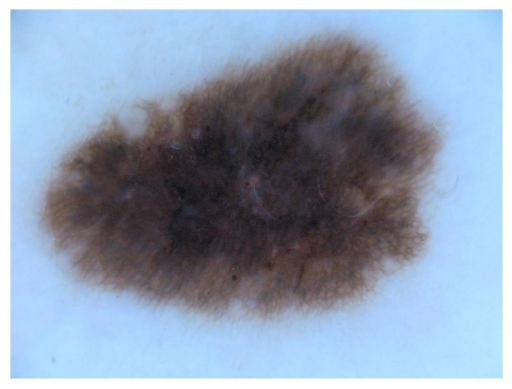

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the absolute file path of the image you want to display
image_path = '/scratch/xw97/jj7317/1-Skin-L-cell-classification/ext-data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg'

# Try opening the image using PIL
try:
    image = Image.open(image_path)
    # Display the image using matplotlib
    plt.figure()
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.show()
except FileNotFoundError as e:
    print("Error:", e)
    print("Please check the file path. Ensure the file exists at the specified location.")

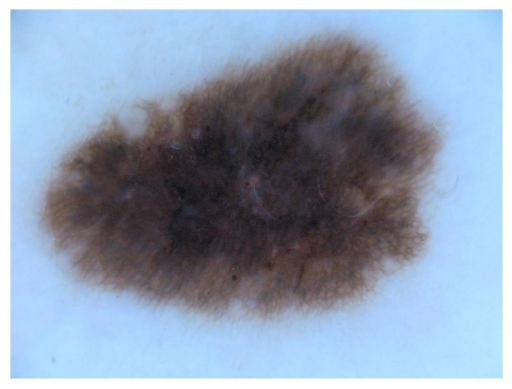

NameError: name 'train_data' is not defined

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the file path of the image you want to display
image_path = '/scratch/xw97/jj7317/1-Skin-L-cell-classification/ext-data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg'

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure()
plt.imshow(image)
plt.axis('off')  # Turn off the axis
plt.show()

### **Step 1:** Define Image Transformations

In [8]:
from torchvision import transforms

transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### **Step 2:** DataLoader

In [10]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define the path to the dataset
path = '/scratch/xw97/jj7317/1-Skin-L-cell-classification/ext-data/ISIC_2019_Training_Input'

dataset = ImageFolder(path, transform=transformations)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, {train_size, val_size})

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### **Step 3:** Custom Model selection

In [18]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained ResNet50 model with the updated method
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer of the model to match the number of classes (9 in this case)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 9)  # 9 classes for our classification

# Move the model to the right device
model = model.to(device)

print("Model has been customized and moved to the device:", device)

Model has been customized and moved to the device: cuda


### **Step 4:** Configure Training Parameters

In [20]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

print("Config successfull")

Config successfull


### **Step 5:** Training Loop

#### ***Trial-1:*** *Basic application*

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        with torch.no_grad():
            val_running_loss = 0.0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

            val_epoch_loss = val_running_loss / len(val_loader.dataset)
            print(f'Validation Loss: {val_epoch_loss:.4f}')

    return model

# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 - Loss: 0.0057
Validation Loss: 0.0000
Epoch 2/10 - Loss: 0.0000
Validation Loss: 0.0000
Epoch 3/10 - Loss: 0.0000
Validation Loss: 0.0000
Epoch 4/10 - Loss: 0.0000
Validation Loss: 0.0000
Epoch 5/10 - Loss: 0.0000
Validation Loss: 0.0000
Epoch 6/10 - Loss: 0.0000
Validation Loss: 0.0000
Epoch 7/10 - Loss: 0.0000
Validation Loss: 0.0000


#### ***Trial-2:*** *Modified*
- Increased model complexity
- Reduced Learning rate

In [ ]:
import torch.nn.functional as F

class CustomResNet(nn.Module):
    def __init__(self, num_classes=9):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.resnet(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create an instance of the modified model
model = CustomResNet()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate to 0.0001

In [ ]:
# # Update the transformations to include normalization
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Apply the transformations to the datasets
# train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# val_dataset = datasets.ImageFolder(val_dir, transform=transform)


#### ***Trial-3:*** *Alternate Loss functions*
`Smooth L1` Loss is less sensitive to outliers than the Mean Squared Error Loss and is often used in regression tasks. However, it can also be used in classification tasks, especially when the problem is formulated as a regression problem (e.g., predicting bounding box coordinates).

In [ ]:
criterion = nn.SmoothL1Loss()